In [1]:
from IPython.display import Image

In [92]:
import numpy as np
import pathlib
from pprint import pprint
import pandas as pd
from util import utils
import re
import os
from copy import deepcopy
import collections
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

# Analysis Across Retrievers
 - NQ only
 - DPR
 - SEAL
 - retriever

## why selection method result varies with the retriever?

| Dataset |  Retriever | Lower | Upper | Selection1 | Selection2 |              Selection3              | Selection4 | Selection5 | Selection6 |
|:-------:|:----------:|:-----:|:-----:|:----------:|:----------:|:------------------------------------:|:----------:|:----------:|:----------:|
|         | DPR        |  52.5 |  62.3 |    58.1    |    56.3    | 61.8 |    61.7    |    55.2    |    56.0    |
|         | SEAL       |  50.0 |  59.4 |    43.9    |    30.0    |             52.9         |    44.9    |    52.5    |    44.6    |
|    NQ   | Contriever |  50.7 |  60.8 |    44.3    |    29.0    |             53.0          |    45.1    |    52.6    |    44.4    |
|         | DPR        |  72.3 |  77.7 |    76.2    |    75.1    | 77.6 |    77.4    |    73.8    |    74.0    |
|         | SEAL       |  67.1 |  72.3 |    67.9    |    51.5    | 72.5     |    63.7    |    72.3    |    63.9    |
|   TQA   | Contriever |  69.7 |  75.5 |    68.4    |    51.7    |             72.5           |    62.9    |    72.3    |    62.9    |

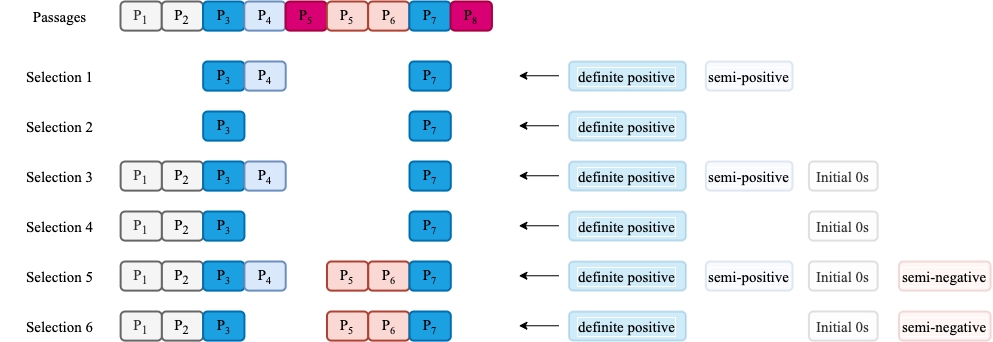

In [3]:
Image(filename='./img/selectionmethod2.drawio의 복사본.png', width=800)

In [ ]:
# distribution of answers on definite positive
# distribution of answers on definite negative

    dpr_dev = extract_statistics(input_data_lst[0], 'method5')
    seal_dev = extract_statistics(input_data_lst[1], 'method5')
    contriever_dev = extract_statistics(input_data_lst[2], 'method5')

In [ ]:
input_file_lst = [
    '/data/philhoon-relevance/FiD/results/TQA_DPR/DEV/incremental_result_100/ctx100.json',
    '/data/philhoon-relevance/FiD/results/TQA_SEAL/DEV/incremental_result_100/ctx100.json',
    '/data/philhoon-relevance/FiD/results/TQA_CONTRIEVER/DEV/incremental_result_100/ctx100.json',
]

## DPR's adversarial training allows to us have more definite positive
#### Need to test this basline DPR versus adversarial trained DPR version
    - 
    - It allows us to filter out semantically similar passages but not helpful to generate the answer.
    - Highly likely to contain more definite positive answers!
    
    
    Mock-up Example
    
     e.g.) Baseline DPR
     When is Sangryul's birthday?
     - Sangryul's birthday was yesterday 
     - Sangryul was born in March 29
     Above are all relevant
     
     e.g.) Adversarial DPR
     When is Sangryul's birthday?
     - Sangryul's birthday was yesterday -> relevant: but unable to answer the answer (not good)
     - Sangryul was born in March 29, 
     Only the second one is relevant

In [ ]:
dpr_dev = '/scratch/philhoon-relevance/FiD/results/NQ_DPR/DEV/incremental_result_100'


In [13]:
print(len(dpr_dev))
print(len(seal_dev))
print(len(contriever_dev))

5456
5202
5331


In [19]:
print((dpr_dev[0].keys()))
print((dpr_dev[0]['definite_positive'].keys()))

dict_keys(['definite_positive', 'definite_negative', 'semi_positive', 'semi_negative', 'initial_zeros'])
dict_keys(['index', 'ctx', 'inference', 'question', 'answers'])


In [154]:
# test = defaultdict(int)
# test['hi'] += 10
# print(test)

In [147]:
def get_dist_by_type_index(data):
    dict_by_type = defaultdict(list)
    dict_by_index = defaultdict(list)
    dict_total_type = defaultdict(int)
        
    for instance in data:
        for key_type, ctx_type in instance.items():
            if not ctx_type:
                continue
            dict_total_type[key_type] += len(ctx_type['index'])
            for answer_ in ctx_type['answers']:
                for index_, ctx_ in zip(ctx_type['index'], ctx_type['ctx']):
                    total_text = ctx_['title'] + ctx_['text']
                    if answer_ in total_text:
                        dict_by_index[index_].append(key_type)
                        dict_by_type[key_type].append(index_) 
    
    return dict_by_type, dict_by_index, dict_total_type

In [151]:
dict_by_type, dict_by_index, dict_total_type = get_dist_by_type_index(dpr_dev)

In [153]:
dict_total_type

defaultdict(int,
            {'definite_positive': 6513,
             'definite_negative': 1912,
             'semi_positive': 440478,
             'semi_negative': 72462,
             'initial_zeros': 24235})

In [156]:
dict_by_type

defaultdict(list,
            {'definite_positive': [0,
              64,
              0,
              5,
              3,
              2,
              0,
              0,
              4,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              21,
              0,
              0,
              0,
              0,
              1,
              0,
              0,
              0,
              0,
              14,
              3,
              2,
              0,
              0,
              6,
              0,
              0,
              0,
              0,
              6,
              0,
              0,
              1,
              2,
              1,
              0,
              0,
              1,
              2,
              1,
              11,
              0,
              0,
              1,
              1,
              27,
              0,
              2,
              0,
    

In [157]:
dict_by_type.keys()

dict_keys(['definite_positive', 'definite_negative', 'semi_negative', 'semi_positive', 'initial_zeros'])

In [160]:
# test = np.ones_like(dict_by_type['initial_zeros'])

In [161]:
# test

array([1, 1, 1, ..., 1, 1, 1])

In [166]:
def plots_by_type_rescale(dict_by_type, dict_total_type):
    bins= [i for i in range(1,102,10)]
    ctx_lst = list(dict_by_type.keys())
    ctx_lst.sort()
    fig, ax = plt.subplots(2,3, figsize=(15, 8), sharex=True, sharey=True)
    cnt = 0
    print(ctx_lst)
    for row in range(2):
        for col in range(3):
            if row == 1 and col ==2:
                break
#             print(cnt)
            ctx_type = ctx_lst[cnt]
            factor = dict_total_type[ctx_type]
            counts = np.ones_like(dict_by_type[ctx_type])
#           weights=factor*np.ones_like(data)
            ax[row][col].hist(dict_by_type[ctx_type], bins=bins, edgecolor="k", weights=counts/factor)
            cnt += 1
#             ax[row][col].xticks(bins)
            
#             ax[row][col].plot(df_normal_lst[cnt]['ctx'], df_normal_lst[cnt]['em'], label='EM', alpha = 0.3, linewidth=5, color = 'blue', marker = "o")    
#             ax[row][col].plot(df_incre_lst[cnt]['ctx'], df_incre_lst[cnt]['em'], label='AcEM', alpha = 0.3, linewidth=5, color = 'red', marker = "*")
#             cnt += 1
#             if row ==0 and col == 0:
#                 ax[row][col].set_title(f'DPR')
#             if row ==0 and col == 1:
#                 ax[row][col].set_title(f'SEAL')
#             if row ==0 and col == 2:
#                 ax[row][col].set_title(f'Contriever')
#             if row == 0 and col == 0:
#                 ax[row][col].set_ylabel(f'Natural Questions', fontsize = 15)
#             if row == 1 and col == 0:
#                 ax[row][col].set_ylabel(f'TriviaQA', fontsize = 15)

    # ax.legend(title='Normal vs Accumulated', fontsize = 'x-small')
    # handles, labels = ax[row][col].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='upper center')


    # lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels, loc='upper center', ncol=2)
#     handles, labels = ax[row][col].get_legend_handles_labels()
#     fig.legend(handles, labels, loc='lower center', ncol=2, fontsize = 15)
#     fig.suptitle('Incremental Inference on Natural Questions, TrivaQA', fontsize = 15)
#     plt.savefig(plot_path, format="pdf", bbox_inches="tight")
    plt.show()


['definite_negative', 'definite_positive', 'initial_zeros', 'semi_negative', 'semi_positive']


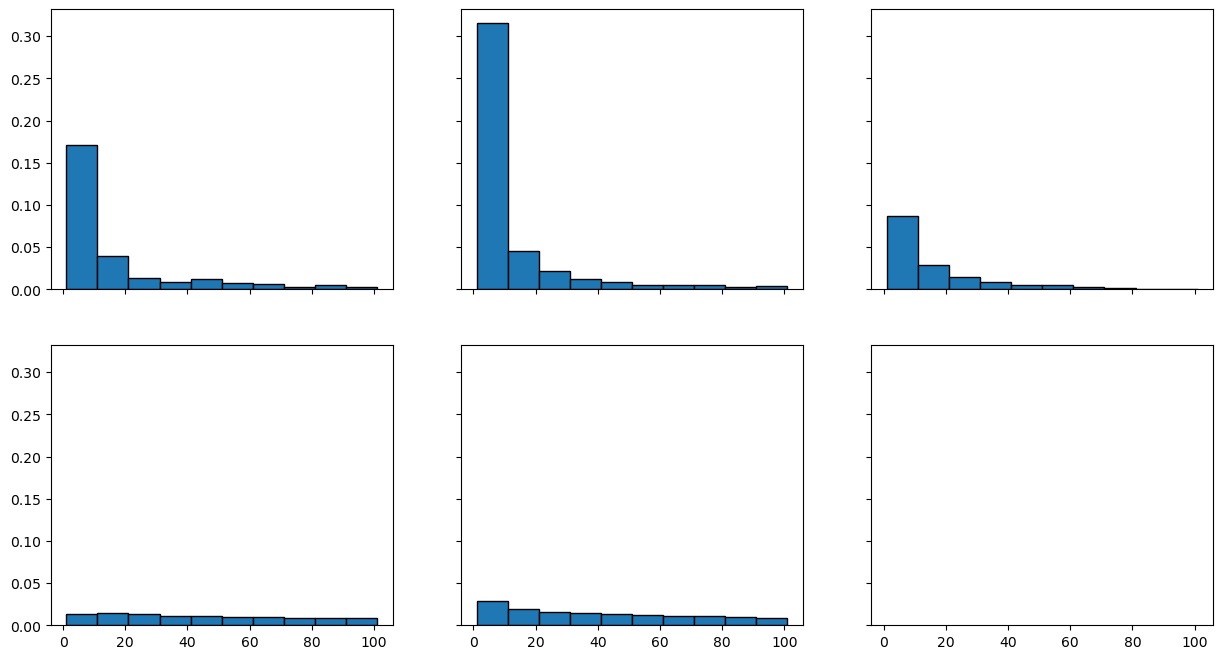

In [168]:
dict_by_type, dict_by_index,dict_total_type = get_dist_by_type_index(dpr_dev)
plots_by_type_rescale(dict_by_type, dict_total_type)

['definite_negative', 'definite_positive', 'initial_zeros', 'semi_negative', 'semi_positive']


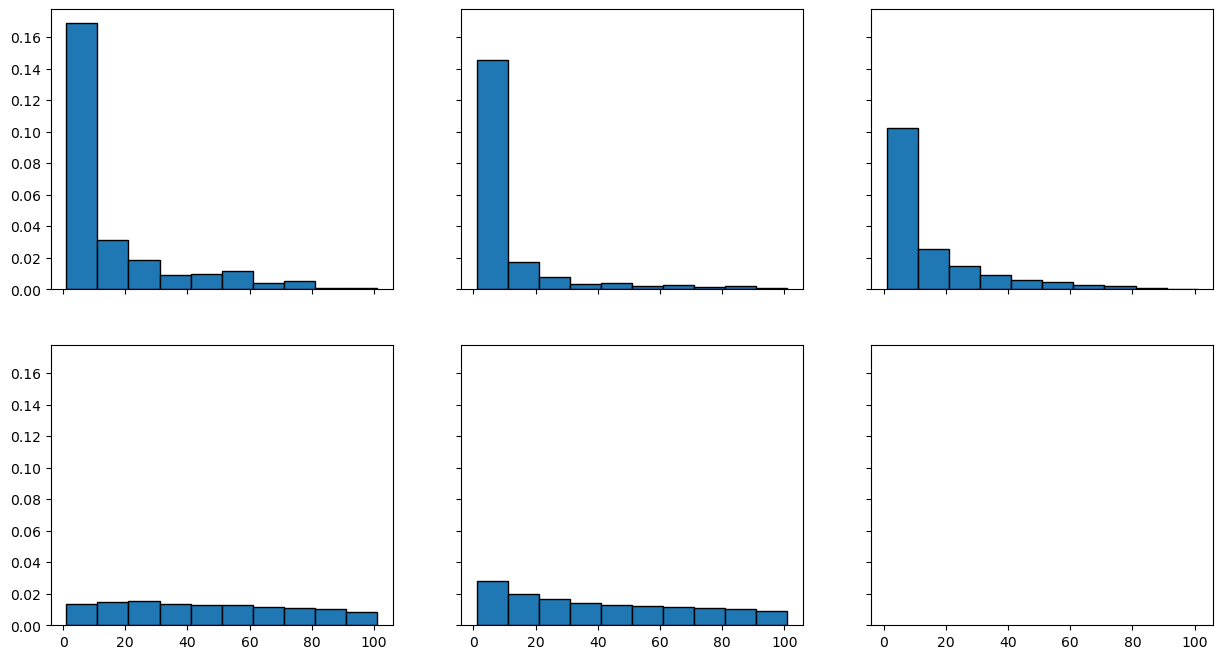

In [169]:
dict_by_type, dict_by_index,dict_total_type = get_dist_by_type_index(seal_dev)
plots_by_type_rescale(dict_by_type, dict_total_type)

['definite_negative', 'definite_positive', 'initial_zeros', 'semi_negative', 'semi_positive']


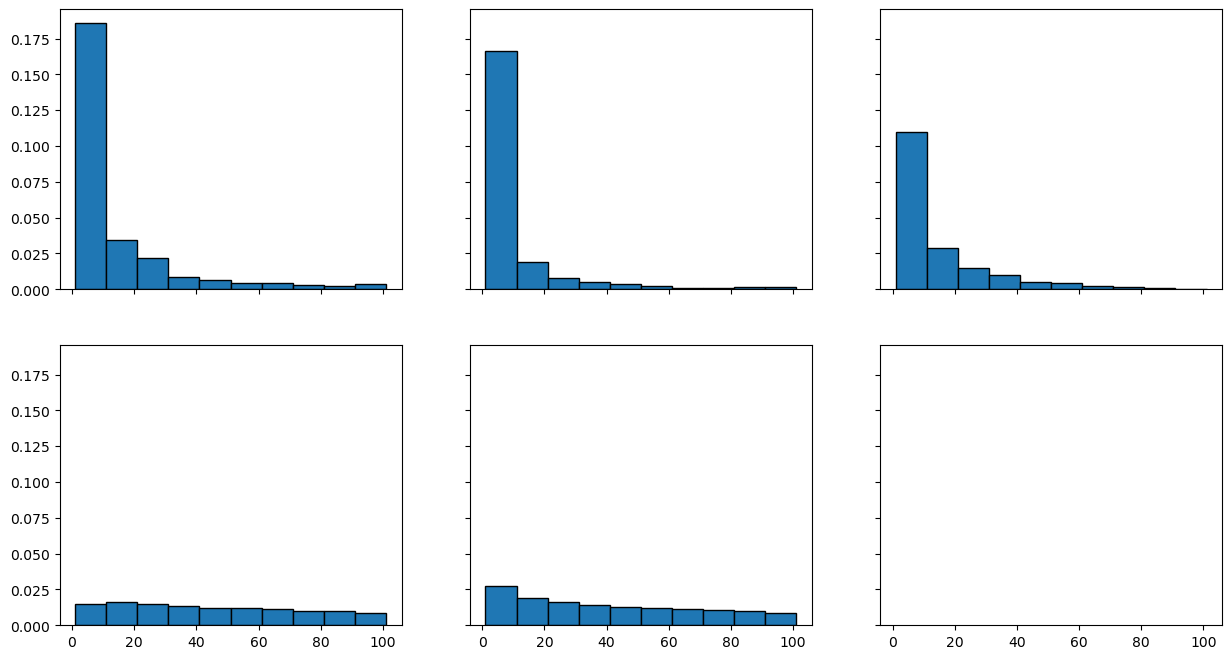

In [170]:
dict_by_type, dict_by_index,dict_total_type = get_dist_by_type_index(contriever_dev)
plots_by_type_rescale(dict_by_type, dict_total_type)

In [98]:
bins

[1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]

In [91]:
# x = np.random.rand(120)
# df = pd.DataFrame({"x":x})

bins= [0,0.35,0.7,1]



range(0, 101, 10)

In [245]:
len(dpr_dev)

6870

In [246]:
test_ = dpr_dev[0]

In [247]:
test_

{'definite_positive': {'index': [0],
  'ctx': [{'id': '7108852',
    'title': 'Vought-Sikorsky VS-300',
    'text': 'Vought-Sikorsky VS-300 The Vought-Sikorsky VS-300 (or S-46) is a single-engine helicopter designed by Igor Sikorsky. It had a single three-blade rotor originally powered by a 75 horsepower (56 kW) engine. The first "free" flight of the VS-300 was on 13 May 1940. The VS-300 was the first successful single lifting rotor helicopter in the United States and the first successful helicopter to use a single vertical-plane tail rotor configuration for antitorque. With floats attached, it became the first practical amphibious helicopter. Igor Sikorsky\'s quest for a practical helicopter began in 1938, when as the Engineering Manager of the Vought-Sikorsky Division'}],
  'inference': ['Helicopter'],
  'question': 'The VS-300 was a type of what?',
  'answers': ['🚁',
   'Helicopters',
   'Civilian helicopter',
   'Pescara (helicopter)',
   'Cargo helicopter',
   'Copter',
   'Heleco

In [301]:
def cnt_ctx_with_answer_index(data, ctx_type):
    cnt = 0
    total_def_positive = 0
#     print(ctx_type)
    for instance in data:
        ctx_dict = instance[ctx_type]
        if not ctx_dict:
            continue
        total_def_positive += len(ctx_dict['index'])
        ctx_idx_cnt = []
        for index_, ctx_ in zip(ctx_dict['index'], ctx_dict['ctx']):
            total_text = ctx_['title'] + ctx_['text']
            for answer_ in ctx_dict['answers']:
                if answer_ in total_text:
                    ctx_idx_cnt.append(index_)
        cnt += len(set(ctx_idx_cnt))
    return cnt, total_def_positive
        
    

In [232]:
# def cnt_ctx_with_answer(data, ctx_type):
#     cnt = 0
#     total_def_positive = 0
# #     print(ctx_type)
#     for instance in data:
#         ctx_dict = instance[ctx_type]
        
#         if not ctx_dict:
#             continue
#         total_def_positive += len(ctx_dict['index'])
#         for answer_ in ctx_dict['answers']:
# #             print(answer_)
#             for ctx_ in ctx_dict['ctx']:
#                 total_text = ctx_['title'] + ctx_['text']
#                 if answer_ in total_text:
#                     cnt += 1
#     return cnt, total_def_positive
        
    

In [241]:
def cnt_ctx_with_answer_3(data, ctx_type):
    cnt = 0
    total_def_positive = 0
#     print(ctx_type)
    for instance in data:
        ctx_dict = instance[ctx_type]
        if not ctx_dict:
            continue
        total_def_positive += len(ctx_dict['index'])
#          ctx_idx_cnt = []
        for ctx_ in ctx_dict['ctx']:
            total_text = ctx_['title'] + ctx_['text']
            for answer_ in ctx_dict['answers']:
                if answer_ in total_text:
                    cnt += 1
    return cnt, total_def_positive

In [302]:
def show_stats_by_ctx_type(data):
    ctx_type_lst = ['definite_positive', 'definite_negative', 'semi_positive', 'semi_negative', 'initial_zeros']
    total_instance_with_anwer = 0
    for ctx_type_ in ctx_type_lst:
        ctx_with_answer, total_ctx = cnt_ctx_with_answer_index(data, ctx_type_)
        print(f'{ctx_type_}')
        print(f'total ctx : {total_ctx}')
        print(f'w/ answer : {ctx_with_answer}')
        print(f'ratio : {ctx_with_answer/total_ctx}')
        total_instance_with_anwer += ctx_with_answer
    print(f'total_instance_with_anwer : {total_instance_with_anwer}')
        

In [303]:
show_stats_by_ctx_type(dpr_dev)

definite_positive
total ctx : 7749
w/ answer : 6068
ratio : 0.783068783068783
definite_negative
total ctx : 1356
w/ answer : 312
ratio : 0.23008849557522124
semi_positive
total ctx : 617739
w/ answer : 145712
ratio : 0.23587955431015364
semi_negative
total ctx : 41517
w/ answer : 4630
ratio : 0.11152058193029361
initial_zeros
total ctx : 18639
w/ answer : 2394
ratio : 0.12844036697247707
total_instance_with_anwer : 159116


In [306]:
show_stats_by_ctx_type(seal_dev)

definite_positive
total ctx : 7317
w/ answer : 4031
ratio : 0.5509088424217575
definite_negative
total ctx : 1379
w/ answer : 364
ratio : 0.2639593908629442
semi_positive
total ctx : 558537
w/ answer : 135909
ratio : 0.24333034337922108
semi_negative
total ctx : 38532
w/ answer : 5382
ratio : 0.1396761133603239
initial_zeros
total ctx : 33835
w/ answer : 8278
ratio : 0.24465789862568346
total_instance_with_anwer : 153964


In [307]:
show_stats_by_ctx_type(contriever_dev)

definite_positive
total ctx : 7654
w/ answer : 4259
ratio : 0.5564410765612752
definite_negative
total ctx : 1490
w/ answer : 399
ratio : 0.2677852348993289
semi_positive
total ctx : 588172
w/ answer : 140800
ratio : 0.23938575790755084
semi_negative
total ctx : 43023
w/ answer : 5603
ratio : 0.1302326662482858
initial_zeros
total ctx : 26861
w/ answer : 6176
ratio : 0.22992442574736607
total_instance_with_anwer : 157237


## Distribution of answers

## NQ TEST DPR 

In [ ]:
# input_file = f'/data/philhoon-relevance/FiD/results/NQ_DPR/TEST/incremental_result_{sample_size}/ctx{sample_size}.json'
# output_path = f'/data/philhoon-relevance/FiD/open_domain_data/NQ_TEST_DPR_SELECTION_NEW/'

In [ ]:
# dataset = 'NQ'
# retriever = 'DPR'
# datatype = 'TEST'
# sample_size = 100

## NQ DEV DPR 

In [ ]:
# dataset = 'NQ'
# retriever = 'DPR'
# datatype = 'DEV'
# sample_size = 100

## NQ DEV SEAL

In [ ]:
# dataset = 'NQ'
# retriever = 'SEAL'
# datatype = 'DEV'
# sample_size = 100

## NQ DEV Contriever

In [ ]:
# dataset = 'NQ'
# retriever = 'CONTRIEVER'
# datatype = 'DEV'
# sample_size = 100

## TQA TEST DPR 

In [ ]:
# dataset = 'TQA'
# retriever = 'DPR'
# datatype = 'TEST'
# sample_size = 100

## TQA DEV DPR 

In [ ]:
# dataset = 'TQA'
# retriever = 'DPR'
# datatype = 'DEV'
# sample_size = 100

## TQA DEV CONTRIEVER 

In [ ]:
# dataset = 'TQA'
# retriever = 'CONTRIEVER'
# datatype = 'DEV'
# sample_size = 100

## TQA DEV SEAL 

In [ ]:
# dataset = 'TQA'
# retriever = 'SEAL'
# datatype = 'DEV'
# sample_size = 100

In [ ]:
# input_file = f'/data/philhoon-relevance/FiD/results/{dataset}_{retriever}/{datatype}/incremental_result_{sample_size}/ctx{sample_size}.json'
# print(input_file)

In [ ]:
# output_path = f'/data/philhoon-relevance/FiD/open_domain_data/{dataset}_{datatype}_{retriever}_SELECTION_NEW_2/'
# print(output_path)

In [ ]:
# print(input_file)
# print(output_path)

In [293]:
# input_file_lst = [
#     '/data/philhoon-relevance/FiD/results/NQ_DPR/DEV/incremental_result_100/ctx100.json',
#     '/data/philhoon-relevance/FiD/results/NQ_SEAL/DEV/incremental_result_100/ctx100.json',
#     '/data/philhoon-relevance/FiD/results/NQ_CONTRIEVER/DEV/incremental_result_100/ctx100.json',
# ]

input_file_lst = [
    '/data/philhoon-relevance/FiD/results/TQA_DPR/DEV/incremental_result_100/ctx100.json',
    '/data/philhoon-relevance/FiD/results/TQA_SEAL/DEV/incremental_result_100/ctx100.json',
    '/data/philhoon-relevance/FiD/results/TQA_CONTRIEVER/DEV/incremental_result_100/ctx100.json',
]

In [294]:
input_data_lst = []
for input_path in input_file_lst:
    input_data_lst.append(utils.open_json(input_path))

In [295]:
def get_definite_pos_neg(test_em):
    positive_pos = []
    if test_em.startswith('1'):
        positive_pos.append(0)
    iter_ = re.finditer(r'01', test_em)
    for m in iter_:
        pos_ = m.start() + 1
        positive_pos.append(pos_)

    negative_pos = []
    iter_ = re.finditer(r'10', test_em)
    for m in iter_:
        pos_ = m.start() + 1
        negative_pos.append(pos_)
    
    return positive_pos, negative_pos

In [296]:
def get_semi_pos(test_em):
    semi_pos = []
    iter_ = re.finditer(r'(?=(11))', test_em)
    for m in iter_:
        semi_pos_ = m.start() + 1
        semi_pos.append(semi_pos_)
    
    return semi_pos

def get_semi_neg(test_em, num_undecisive):
    semi_neg = []
    test_em_temp = test_em[num_undecisive:]
    iter_ = re.finditer(r'(?=(00))', test_em_temp)
    for m in iter_:
        semi_neg_ = m.start() + 1
        semi_neg.append(semi_neg_)
    semi_neg = [i + num_undecisive for i in semi_neg]
    return semi_neg

In [297]:
def extract_statistics(input_file, method):
    output_format = []
    statistics_lst = []
    for id_, instance in enumerate(input_file, 1):
        output_dict = {}
        
        template_dict = {}
        if 'id' in instance.keys():
            template_dict['id'] = instance['id']
        else:
            template_dict['id'] = str(id_)
        template_dict['answers'] = instance['answers']
        template_dict['question'] = instance['question']
        template_dict['em_pattern'] = instance['em_pattern']

        em_pattern = deepcopy(instance['em_pattern'])
        instances_ = deepcopy(instance['ctxs'])
        instances_inference = deepcopy(instance['inference'])
        num_undecisive = len(em_pattern) - len(em_pattern.lstrip('0'))

        
        ## Meaing no EM
        if num_undecisive == 100:
            template_dict['ctxs']= instance['ctxs']
            output_format.append(template_dict)
        ## Meaning EM
        else:
#          check_lst = []
            # initial zeros
            new_context = []
            initial_zeros_lst = [i for i in range(0, num_undecisive)]

            # defnitie positive, definite negative
            defnite_positve_lst, defnite_negative_lst = get_definite_pos_neg(em_pattern)

            # semi positive, semi negative
            semi_positive_lst = get_semi_pos(em_pattern)
            semi_negative_lst = get_semi_neg(em_pattern, num_undecisive)

            if method == 'method1':
                new_context.extend(defnite_positve_lst)
                new_context.extend(semi_positive_lst)

            elif method == 'method2':
                new_context.extend(defnite_positve_lst)

            elif method == 'method3':
                new_context.extend(defnite_positve_lst)
                new_context.extend(semi_positive_lst)
                new_context.extend(initial_zeros_lst)
                
            elif method == 'method4':
                new_context.extend(defnite_positve_lst)
                new_context.extend(initial_zeros_lst)
                
            elif method == 'method5':
                defnite_positve_ctx_lst = [instances_[i] for i in defnite_positve_lst]
                defnite_negative_ctx_lst = [instances_[i] for i in defnite_negative_lst]
                semi_positive_ctx_lst = [instances_[i] for i in semi_positive_lst]
                semi_negative_ctx_lst = [instances_[i] for i in semi_negative_lst]
                initial_zeros_ctx_lst = [instances_[i] for i in initial_zeros_lst]
                
                defnite_positve_inference_lst = [instances_inference[i] for i in defnite_positve_lst]
                defnite_negative_inference_lst = [instances_inference[i] for i in defnite_negative_lst]
                semi_positive_inference_lst = [instances_inference[i] for i in semi_positive_lst]
                semi_negative_inference_lst = [instances_inference[i] for i in semi_negative_lst]
                initial_zeros_inference_lst = [instances_inference[i] for i in initial_zeros_lst]
                
                output_dict['definite_positive'] = {
                    'index' : defnite_positve_lst,
                    'ctx' : defnite_positve_ctx_lst,
                    'inference' : defnite_positve_inference_lst,
                    'question' : instance['question'],
                    'answers' : instance['answers'],
                }
                
                output_dict['definite_negative'] = {
                    'index' : defnite_negative_lst,
                    'ctx' : defnite_negative_ctx_lst,
                    'inference' : defnite_negative_inference_lst,
                    'question' : instance['question'],
                    'answers' : instance['answers'],
                }                

                output_dict['semi_positive'] = {
                    'index' : semi_positive_lst,
                    'ctx' : semi_positive_ctx_lst,
                    'inference' : semi_positive_inference_lst,
                    'question' : instance['question'],
                    'answers' : instance['answers'],
                }                            

                output_dict['semi_negative'] = {
                    'index' : semi_negative_lst,
                    'ctx' : semi_negative_ctx_lst,
                    'inference' : semi_negative_inference_lst,
                    'question' : instance['question'],
                    'answers' : instance['answers'],
                }            
                
                output_dict['initial_zeros'] = {
                    'index' : initial_zeros_lst,
                    'ctx' : initial_zeros_ctx_lst,
                    'inference' : initial_zeros_inference_lst,
                    'question' : instance['question'],
                    'answers' : instance['answers'],
                }  
                statistics_lst.append(output_dict)

            elif method == 'method6':
                new_context.extend(defnite_positve_lst)
                new_context.extend(semi_negative_lst)
                new_context.extend(initial_zeros_lst)

            if [item for item, count in collections.Counter(new_context).items() if count > 1]:
                print('Duplicates index!')
            else:
                new_context_lst = [instances_[i]for i in new_context]

            template_dict['ctxs'] = new_context_lst
            output_format.append(template_dict)
    return statistics_lst

In [298]:
# input_data_lst[0][0].keys()

In [299]:
print(len(input_data_lst[0]))
print(len(input_data_lst[1]))
print(len(input_data_lst[2]))

8837
8837
8837


In [300]:
dpr_dev = extract_statistics(input_data_lst[0], 'method5')
seal_dev = extract_statistics(input_data_lst[1], 'method5')
contriever_dev = extract_statistics(input_data_lst[2], 'method5')

In [ ]:
method_lst = [
#     'method1',
#     'method2',
    'method3',
#     'method4',
#     'method5',
#     'method6'
]

In [ ]:
method_lst

In [ ]:
output_path

In [ ]:
check_method = []
for method in method_lst:

    filename = f'{method}.json'
    output_file = os.path.join(output_path, filename)
    print(output_file)
    output_data = build_data_3(input_, method)
    check_method.append(output_data)
    utils.save_json(output_data, output_file)
    print(f'{output_file} saved')
            

## Mtehod1 Verify

In [ ]:
def m1_v(output_format):
    for iins_ in output_format:
        check_counter = collections.Counter(iins_['em_pattern'])
        if check_counter['1'] == 0 and len(iins_['ctxs']) != 100:
            print('context not 100 when no answer')
        if check_counter['1'] > 1 and check_counter['1'] != len(iins_['ctxs']):
            print('context number not match')
        check_counter = None

In [ ]:
m1_v(check_method[0])

## Mtehod2 Verify

In [ ]:
def m2_v(output_format):
    for iins_ in output_format:
        positive_pos, negative_pos = get_definite_pos_neg(iins_['em_pattern'])
        check_counter = collections.Counter(iins_['em_pattern']) 
        if check_counter['0'] == 100 and len(iins_['ctxs']) != 100:
            print('context not 100 when no answer')
        if check_counter['0'] != 100 and len(iins_['ctxs']) != len(positive_pos):
            print(positive_pos)
            print(len(iins_['ctxs']))
            print('context number not match')
        check_counter = None

In [ ]:
m2_v(check_method[1])

## Mtehod3 Verify

In [ ]:
def m3_v(output_format):
    for iins_ in output_format:
        positive_pos, negative_pos = get_definite_pos_neg(iins_['em_pattern'])
        semi_pos = get_semi_pos(iins_['em_pattern'])
        num_undecisive = len(iins_['em_pattern']) - len(iins_['em_pattern'].lstrip('0'))
        
        if num_undecisive == 100 and len(iins_['ctxs']) != 100:
            print('context not 100 when no answer')
        if num_undecisive != 100 and len(iins_['ctxs']) != len(positive_pos) + len(semi_pos) + num_undecisive:
            print(iins_['em_pattern'])
            print(len(positive_pos))
            print(len(semi_pos))
            print(num_undecisive)
            print(len(iins_['ctxs']))
            print('context number not match')

In [ ]:
m3_v(check_method[0])

## Method4 Verify

In [ ]:
def m4_v(output_format):
    for iins_ in output_format:
        positive_pos, negative_pos = get_definite_pos_neg(iins_['em_pattern'])
        num_undecisive = len(iins_['em_pattern']) - len(iins_['em_pattern'].lstrip('0'))
        
        if num_undecisive == 100 and len(iins_['ctxs']) != 100:
            print('context not 100 when no answer')
        if num_undecisive != 100 and len(iins_['ctxs']) != len(positive_pos) + num_undecisive:
            print(iins_['em_pattern'])
            print(len(positive_pos))
            print(len(semi_pos))
            print(num_undecisive)
            print(len(iins_['ctxs']))
            print('context number not match')

In [ ]:
m4_v(check_method[3])

## Method5 Verify

In [ ]:
def m5_v(output_format):
    for iins_ in output_format:
        positive_pos, negative_pos = get_definite_pos_neg(iins_['em_pattern'])
        semi_pos = get_semi_pos(iins_['em_pattern'])
        num_undecisive = len(iins_['em_pattern']) - len(iins_['em_pattern'].lstrip('0'))
        semi_neg = get_semi_neg(iins_['em_pattern'], num_undecisive)
            
        if num_undecisive == 100 and len(iins_['ctxs']) != 100:
            print('context not 100 when no answer')
        if num_undecisive != 100 and len(iins_['ctxs']) != len(positive_pos) + len(semi_pos) + len(semi_neg) + num_undecisive:
            print(iins_['em_pattern'])
            print(len(positive_pos))
            print(len(semi_pos))
            print(num_undecisive)
            print(len(iins_['ctxs']))
            print('context number not match')

In [ ]:
m5_v(check_method[4])

## Method6 Verify

In [ ]:
def m6_v(output_format):
    for iins_ in output_format:
        positive_pos, negative_pos = get_definite_pos_neg(iins_['em_pattern'])
#         semi_pos = get_semi_pos(iins_['em_pattern'])
        num_undecisive = len(iins_['em_pattern']) - len(iins_['em_pattern'].lstrip('0'))
        semi_neg = get_semi_neg(iins_['em_pattern'], num_undecisive)
            
        if num_undecisive == 100 and len(iins_['ctxs']) != 100:
            print('context not 100 when no answer')
        if num_undecisive != 100 and len(iins_['ctxs']) != len(positive_pos) + len(semi_neg) + num_undecisive:
            print(iins_['em_pattern'])
            print(len(positive_pos))
            print(len(semi_pos))
            print(num_undecisive)
            print(len(iins_['ctxs']))
            print('context number not match')

In [ ]:
m6_v(check_method[5])

In [ ]:
# output_path

In [ ]:
# for 